![logo](../img/cems_header.png)

<br>

# Observing major flood events with GLOFAS

## About

This tutorial will demonstrate how to investigate a specific flood event using data from the GLObal Flood
Awareness Service (GLOFAS). For this example we look at the major flood event in Bangladesh in June 2022
and look at the excess river discharge in comparison to the long-term (10-year) discharge statistics.

The GLOFAS data is produced operationally by ECMWF for the Copernicus Emergency Management Service (CEMS).

The tutorial is structured as follows:

0. (Install and import the required python packages)
1. Download the data of interest from the C3S Climate Data Store (CDS);
1. Explore the data with xarray, apply mask using the auxilary data, and produce demonstrative map plots;
1. Compute and plot time-series of the June 2022 river discharge against the 10-year period;
1. Compute and display a map of the number of days in June 2022 that the river discharge exceeded the
  90th percentile of the 10-year period.

The steps and methods here serve as demonstrative examples and could be applied to other events and datasets,
e.g. fire and heatwave events.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s-review/review?labpath=glofas-bangladesh-floods.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s-review/blob/review/glofas-bangladesh-floods.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s-review/blob/review/glofas-bangladesh-floods.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

## Search, download and view data

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### Install CDS API

To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [1]:
!pip -q install cdsapi

# Other requirements:
!pip -q install cfgrib ecmwflibs
!pip -q install xarray netcdf4
!pip -q install matplotlib
!pip -q install cartopy


### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [2]:
import os

# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

### Enter your CDS API key

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.

If you have set up your cdsapi key using a ~/.cdsapirc the following is not required and cdsapi_kwargs can be left as an empty dictionary.

In [3]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'
cdsapi_kwargs = {
    # 'url': URL,
    # 'key': KEY,
}

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [4]:
DATADIR = './data_dir'
os.makedirs(DATADIR, exist_ok=True)

### Search for the river discharge data we want

The historical GLOFAS data can be found in 
[CDS catalogue entry](https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-glofas-historical).

We are going to look at the Bangladesh flood in June 2022. For our analysis we are going to compare June 2022
against all the June data from the 10-year reference period: 2013 to 2022. This period has been chosen for
demonstrative purposes, a thorough analysis would choose a much longer reference period.




For our study we are going to make the following selection on the download page:

- **System version**: version 4.0
- **Hydrological model**: LISFLOOD
- **Product type**: Consolidated
- **Variable**: River discharge in the last 24 hours'
- **Year**: 2013 to 2022
- **Month**: June
- **Day**: All days
- **Area**: [30, 85, 20, 95,] = A bounding box for Bangladesh
- **Format**: Grib

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cells below).

#### Download data

... having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the **terms and conditions** of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **"Show API request"** option.

In [16]:
download_file = f"{DATADIR}/download.grib"
if not os.path.isfile(download_file):
    c = cdsapi.Client(
        # **cdsapi_kwargs
    )
    c.retrieve(
        'cems-glofas-historical',
        {
            'system_version': 'version_4_0',
            'hydrological_model': 'lisflood',
            'product_type': 'consolidated',
            'variable': 'river_discharge_in_the_last_24_hours',
            'hyear': [f"{year}" for year in range(2013, 2023)],
            'hmonth': 'june',
            'hday': [f"{day:02d}" for day in range(1,31)],
            'format': 'grib',
            'area': [30, 85, 20, 95,],
        },
    ).download(download_file)

2023-02-08 09:45:26,121 INFO Welcome to the CDS
2023-02-08 09:45:26,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical
2023-02-08 09:45:26,276 INFO Request is queued
2023-02-08 09:45:27,321 INFO Request is running


#### Opening the data

We open the data with xarray which can handle both grib and netcdf formats. The xarray dataset objects allows
exploration of the data contents including attributes, metadata and coordinates.


In [15]:
glofas_data = xr.open_dataset(download_file)
glofas_data

<xarray.Dataset>
Dimensions:     (time: 330, latitude: 202, longitude: 202)
Coordinates:
  * time        (time) datetime64[ns] 2012-06-01 2012-06-02 ... 2022-06-30
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.02 29.97 29.92 29.87 ... 20.07 20.02 19.97
  * longitude   (longitude) float64 84.97 85.02 85.07 ... 94.92 94.97 95.02
    valid_time  (time) datetime64[ns] ...
Data variables:
    dis24       (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-02-08T09:45 GRIB to CDM+CF via cfgrib-0.9.9...

#### Getting an overview of the study area

Now we will produce a simple map of the data. First we will define a function for producing a map plot that
we will use several times in this note book:

In [8]:
# Create a simple plotting function that we can use throughout this notebook
def plot_map(
    plot_data,
    title='',
    cbar_label='',
    cmap='summer_r',
    extent=[85, 95, 20, 30],
    **pcolorkwargs
):
    # Populate the title and cbar_label with attributes from the plot_data if they have not been
    #  explicitly specified
    title = title or plot_data.attrs.get('long_name', title)
    cbar_label = cbar_label or plot_data.attrs.get('units', cbar_label)

    # Create a figure with a cartopy projection assigned which allows plotting geospatial data
    fig, ax = plt.subplots(
        1, 1, figsize = (18, 9), subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Plot the data on our figure
    im = ax.pcolormesh(
        plot_data.longitude, plot_data.latitude, plot_data, cmap=cmap, **pcolorkwargs
    )

    # Add some additional features
    ax.set_title(title, fontsize=16)
    ax.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    ax.coastlines(color='black')

    # Add country borders in red
    ax.add_feature(cfeature.BORDERS, color='red', lw=1.5)

    # Set the plot domain/extent
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add a colour bar
    cbar = plt.colorbar(im,fraction=0.04, pad=0.01)
    cbar.set_label(cbar_label, fontsize=12) 

To produce the map plot, we first need to flatten the time dimension.
This can be done by either specifying a date (e.g. glofas_data.dis24.isel(time=1)) or by taking a value
such as the mean as we do here:

/Users/edwardcomyn-platt/miniconda3/envs/CDS/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


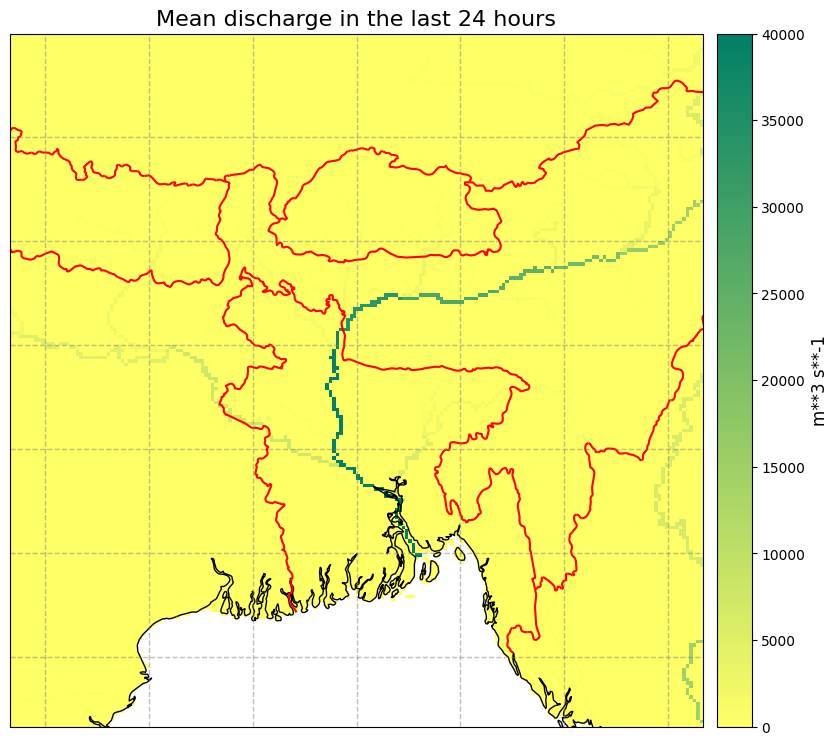

In [9]:
mean_data = glofas_data.dis24.mean(dim='time')
mean_data = mean_data.assign_attrs(**glofas_data.dis24.attrs)
plot_map(
    mean_data,
    vmax=40e3, vmin=0
)

#### Accessing the upstream area data
We know that the river discharge is only valid in the rivers, therefore it is possible to mask the data with
knowledge of the the river locations. We do this by using the upstream area data which is provided as an
auxilary data product for GloFAS. The upstream area denotes the total upstream area for each river pixel, 
expressed in m2. More information can be found on the 
[CEMS-Floods auxiliary data page](https://confluence.ecmwf.int/display/CEMS/Auxiliary+Data).

Below we download the data directly and open the netCDF file using xarray.


In [10]:
# choose a target location to download the file:
upstream_area_file = f"{DATADIR}/uparea_glofas_v4_0.nc"
# If we have not already downloaded the file, we download it
if not os.path.isfile(upstream_area_file):
   u_version=2 # file version
   upstream_data_url = (
      f"https://confluence.ecmwf.int/download/attachments/242067380/{upstream_area_file}?"
      f"version={u_version}&modificationDate=1668604690076&api=v2&download=true"
   )
   os.system(f"wget -q {upstream_data_url}")
   os.rename(f"{upstream_area_file}?version={u_version}", upstream_area_file)

# Open the file and print the contents
upstream_area = xr.open_dataset(upstream_area_file)
upstream_area

<xarray.Dataset>
Dimensions:    (longitude: 7200, latitude: 3000)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * latitude   (latitude) float64 89.97 89.92 89.88 ... -59.88 -59.92 -59.97
Data variables:
    uparea     (latitude, longitude) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    Conventions:                CF-1.9
    GDAL_PCRASTER_VALUESCALE:   VS_SCALAR
    GDAL_AREA_OR_POINT:         Area
    GDAL:                       GDAL 3.2.1, released 2020/12/29
    NCO:                        netCDF Operators version 4.9.7 (Homepage = ht...
    history_of_appended_files:  Fri Dec 10 11:49:42 2021: Appended file ldd_O...
    history:                    Mon Nov 14 17:49:16 2022: cdo chname,lon,long...
    CDO:                        Climate Data Operators version 1.9.10 (https:...

## Reduce to the domeain of the data

The upstream area data covers the entire globe, we must therefore reduce it to the domain of our area of
interest, Bangladesh. To avoid hard-coding and to ensure that the sub-area selected matches exactly 
we extract the domain limits from the river discarge data.

In [11]:
# Reduce the Upstream area data to the domain of the river discharge

# Get the latitude and longitude limits of the data
lat_limits = [glofas_data.latitude.values[i] for i in [0, -1]]
lon_limits = [glofas_data.longitude.values[i] for i in [0, -1]]
up_lats = upstream_area.latitude.values.tolist()
up_lons = upstream_area.longitude.values.tolist()

lat_slice_index = [
    round((i-up_lats[0])/(up_lats[1]-up_lats[0]))
    for i in lat_limits
]
lon_slice_index = [
    round((i-up_lons[0])/(up_lons[1]-up_lons[0]))
    for i in lon_limits
]

# Slice upstream area to bangladesh region:
red_upstream_area = upstream_area.isel(
    latitude=slice(lat_slice_index[0], lat_slice_index[1]+1),
    longitude=slice(lon_slice_index[0], lon_slice_index[1]+1),
)

# There are very minor rounding differences, so we update with the lat/lons from the glofas data
red_upstream_area = red_upstream_area.assign_coords({
    'latitude': glofas_data.latitude,
    'longitude': glofas_data.longitude,
})

# Add the upstream area to the main data object and print the updated glofas data object:
glofas_data['uparea'] = red_upstream_area['uparea']
glofas_data

<xarray.Dataset>
Dimensions:     (time: 330, latitude: 202, longitude: 202)
Coordinates:
  * time        (time) datetime64[ns] 2012-06-01 2012-06-02 ... 2022-06-30
    step        timedelta64[ns] 1 days
    surface     float64 0.0
  * latitude    (latitude) float64 30.02 29.97 29.92 29.87 ... 20.07 20.02 19.97
  * longitude   (longitude) float64 84.97 85.02 85.07 ... 94.92 94.97 95.02
    valid_time  (time) datetime64[ns] 2012-06-02 2012-06-03 ... 2022-07-01
Data variables:
    dis24       (time, latitude, longitude) float32 0.0 0.0 ... 3.034e+04
    uparea      (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-02-08T09:25 GRIB to CDM+CF via cfgrib-0.9.9...

### Mask data

We now mask the data to where the upstream area is >= 250km2, and plot it to see how it looks

/Users/edwardcomyn-platt/miniconda3/envs/CDS/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


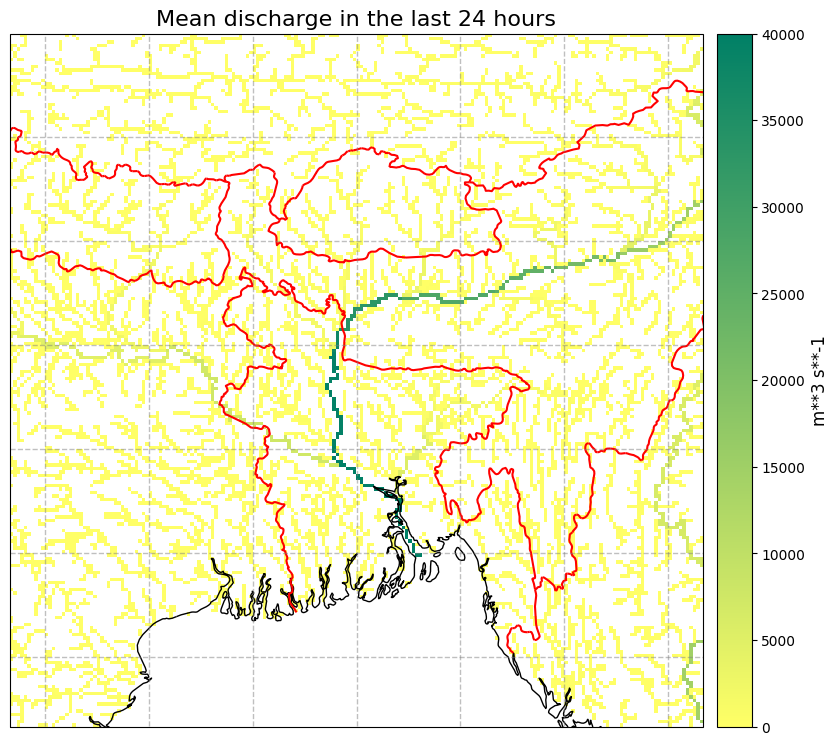

In [12]:
glofas_data_masked = glofas_data.where(glofas_data.uparea>=250.e6)
mean_masked_data = glofas_data_masked.dis24.mean(dim='time').assign_attrs(glofas_data_masked.dis24.attrs)
plot_map(
    mean_masked_data,
    vmax=40e3, vmin=0
)

#### Calculating the climatology
First, let's see how severe these 2022 floods were for the area as a whole, when compared to 2013-2021 data.

In [92]:
# select the 2012-2021 data
glofas_historical_dates = glofas_data_masked.sel(time=slice("2012","2021"))

# calculate the mean discharge over the whole domain, for each day in June
glofas_xy_climatology = glofas_historical_dates.dis24.mean(["longitude", "latitude"]).groupby('time.day').mean("time")

# calculate the minimum and maximum discharge over the whole domain, for each day in June
glofas_xy_clim_min = glofas_historical_dates.dis24.mean(["longitude", "latitude"]).groupby('time.day').min("time")
glofas_xy_clim_max = glofas_historical_dates.dis24.mean(["longitude", "latitude"]).groupby('time.day').max("time")
# Calculate the 10th and 90th percentiles of discharge rate of the whole domain
glofas_xy_clim_quantiles = glofas_historical_dates.dis24.mean(
    ["longitude", "latitude"]
).groupby('time.day').quantile(dim="time", q=[0.1,0.9])

# calculate the mean discharge over the whole domain for each day in June 2022
glofas_xy_2022 = glofas_data_masked.dis24.sel(time="2022")
glofas_xy_2022_mean = glofas_xy_2022.mean(['longitude','latitude']).groupby('time.day').mean("time")

Now let's plot the data..

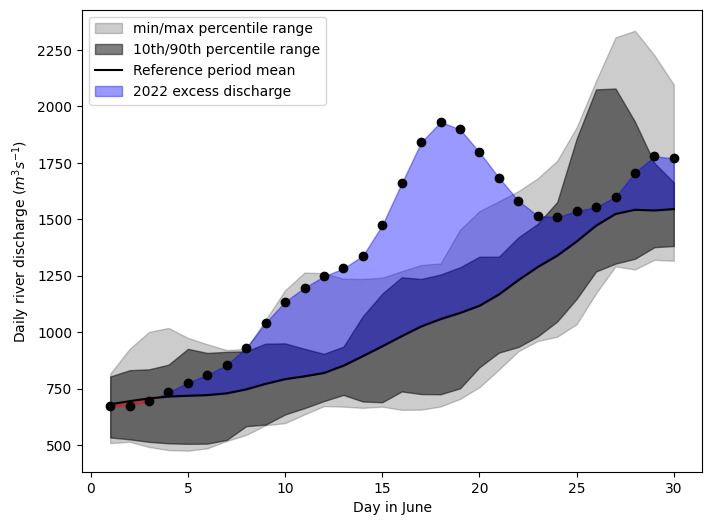

In [99]:
from statistics import quantiles


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

ax.fill_between(
    np.arange(1, 31), glofas_xy_clim_min.values, glofas_xy_clim_max.values,
    color="k", alpha=0.2, label='min/max percentile range'
)

ax.fill_between(
    np.arange(1, 31),
    glofas_xy_clim_quantiles.isel(quantile=0).values,
    glofas_xy_clim_quantiles.isel(quantile=1).values,
    color="k", alpha=0.5, label='10th/90th percentile range'
)

(line_base,) = plt.plot(
    np.arange(1, 31), glofas_xy_climatology.values, color="k", label="Reference period mean"
)

ax.fill_between(
    range(1, int(glofas_xy_2022_mean.shape[0]) + 1),
    glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    glofas_xy_2022_mean.values,
    color="b",
    alpha=0.4,
    where=glofas_xy_2022_mean.values >= glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    interpolate=True, label="2022 excess discharge"
)

ax.fill_between(
    range(1, int(glofas_xy_2022_mean.shape[0]) + 1),
    glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    glofas_xy_2022_mean.values,
    color="r",
    alpha=0.4,
    where=glofas_xy_2022_mean.values < glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    interpolate=True,
)

dots = ax.scatter(
    range(1, int(glofas_xy_2022_mean.shape[0]) + 1),
    glofas_xy_2022_mean.values,
    color="k",
    # label="2022",
    zorder=2,
)
ax.legend(loc='upper left')
plt.xlabel("Day in June")
plt.ylabel("Daily river discharge ($m^{3}s^{-1}$)")
plt.show()

From this plot, we see that around the 13th of June the 2022 floods began to exceed the 10-year historical maximum, and this continued until the 22nd.

However, this plot doesn't give us an idea of how the severity of the flooding varied spatially, so let's have a look at that.

In [101]:
# Calculate the climatology
glofas_climatology = glofas_data_masked.groupby('time.dayofyear').mean("time")
glofas_climat_quantiles = glofas_data_masked.groupby('time.dayofyear').quantile(dim="time", q=[0.1,0.5,0.9])

# # Calculate the anomaly w.r.t the above climatology
# glofas_anomaly = glofas_data_masked.groupby('time.dayofyear') - glofas_climatology
# # Calculate this a relative anomaly
# glofas_relanom = glofas_anomaly.groupby('time.dayofyear')/glofas_climatology

glofas_high = glofas_data_masked.groupby('time.dayofyear') > glofas_climat_quantiles.sel(quantile=0.9)
glofas_high = glofas_high.where(glofas_data.uparea>250e6)


/Users/edwardcomyn-platt/miniconda3/envs/JUPYTER-DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/Users/edwardcomyn-platt/miniconda3/envs/JUPYTER-DEVELOP/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


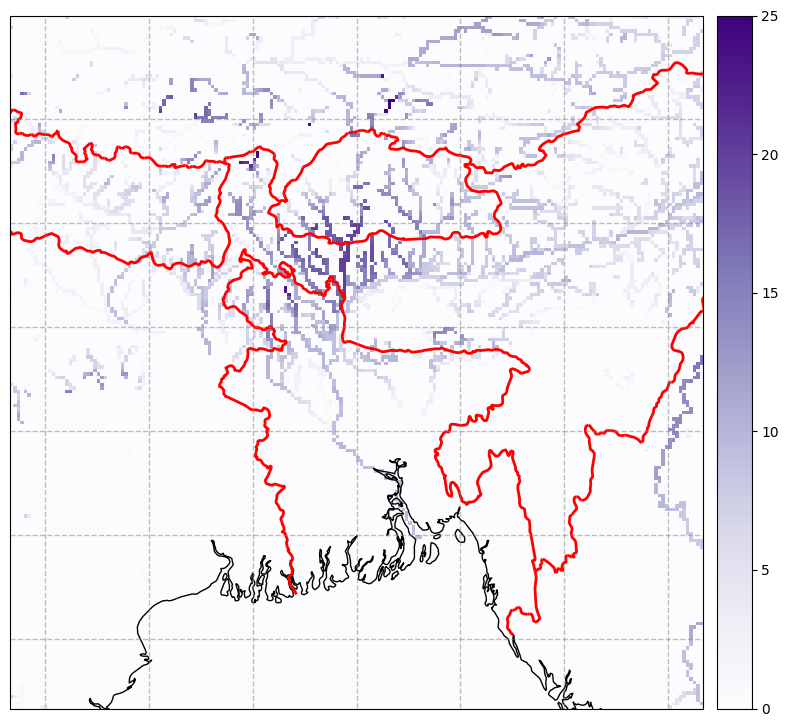

In [126]:
# Plot the data:
year='2022'
number_of_high_days = glofas_high.sel(time=year).dis24.sum(dim='time')
number_of_high_days = number_of_high_days.assign_attrs(glofas_high.dis24.attrs)
plot_map(
    number_of_high_days, vmax=25, cmap='Purples'
)

We can see that some areas to the northeast of Dhaka experienced discharge exceeding the 90th percentile for over 20 days in June.

/Users/edwardcomyn-platt/miniconda3/envs/JUPYTER-DEVELOP/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


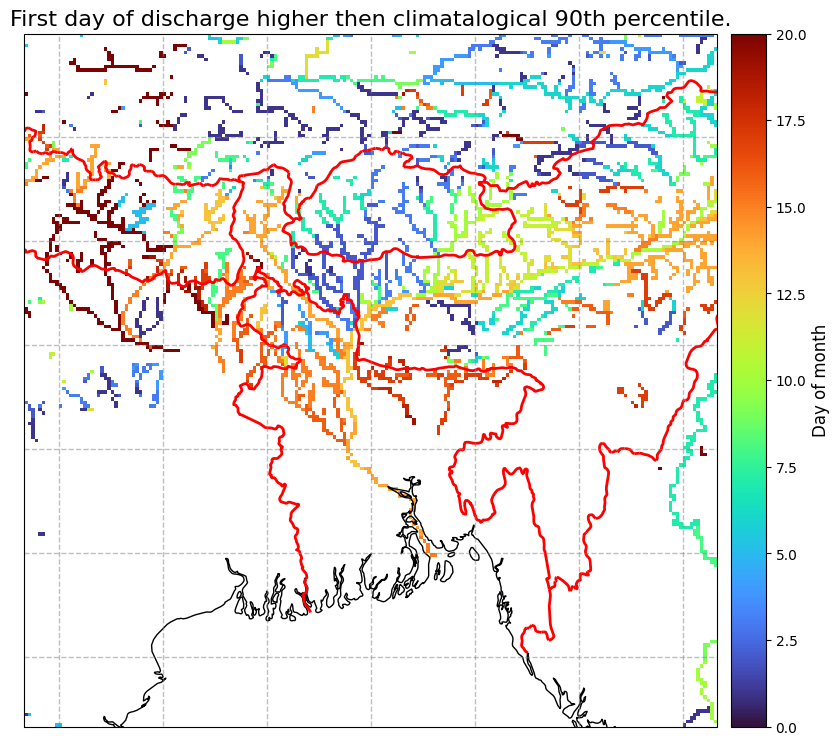

In [127]:
year='2022'
glofas_high_this_year = glofas_high.sel(time=year)

first_high_day = np.zeros_like(number_of_high_days)
for i in range(30):
    this_high_day = i*glofas_high_this_year.isel(time=i)
    first_high_day[first_high_day==0] = this_high_day.dis24.values[first_high_day==0]
first_high_day[first_high_day==0] = np.nan
first_high_day = xr.DataArray(
    first_high_day,
    name='first_day_of_high_discharge',
    dims = number_of_high_days.dims,
    coords=number_of_high_days.coords,
    attrs={
        'units': 'Day of month',
        'long_name': 'First day of discharge higher then climatalogical 90th percentile.'
    }
)

plot_map(first_high_day, cmap='turbo', vmin=0, vmax=20)


In [120]:
first_high_day

<xarray.DataArray 'first_day_of_high_discharge' (latitude: 202, longitude: 202)>
array([[nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, 10.,  0.],
       [nan, nan, nan, ..., nan, nan, 10.],
       [nan, nan, nan, ..., nan, nan, 10.]])
Coordinates:
    step       timedelta64[ns] 1 days
    surface    float64 0.0
  * latitude   (latitude) float64 30.02 29.97 29.92 29.87 ... 20.07 20.02 19.98
  * longitude  (longitude) float64 84.97 85.02 85.07 85.12 ... 94.92 94.97 95.03